# Dependency Parsing with Eisner
Par Louis GERARD & Tiago CORTINHAL

In [1]:
import sys
venv_root = '/var/lib/vz/data/g13005245/DEEP/'
sys.path.append(venv_root + 'lib/python3.5/site-packages')

import warnings
warnings.filterwarnings('ignore')

import utils
import f1
import f2

import time
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec

Using TensorFlow backend.


## Features 1

We start building a model on these features :
- Governor POS
- Dependant POS
- Distance between these words

### Read data

We read the conllu file to get aall the info we need. In order to make this reusable, we can add any feature to the final list by adding its index to `features_enabled`. Here we have :
- the index, to identify our token
- the part of speech, which we want to pass to our model
- the governor index, to build pairs

In [2]:
sentence = f1.sentences_fr_train[3]
pd.DataFrame(sentence)

,0,1,2,3
0,0,ROOT,0,root
1,1,ADV,5,advmod
2,2,PUNCT,5,punct
3,3,DET,4,det
4,4,NOUN,5,nsubj
5,5,VERB,0,root
6,6,DET,7,det
7,7,NOUN,5,obj
8,8,PUNCT,5,punct


### Projectivity

In [3]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_fr_train, f1)
counter_p, '%.2f %%' % proportion_p

(1169, '8.03 %')

In [4]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_fr_dev, f1)
counter_p, '%.2f %%' % proportion_p

(113, '7.65 %')

In [5]:
counter_p, proportion_p = utils.count_projectives(f1.sentences_fr_test, f1)
counter_p, '%.2f %%' % proportion_p

(18, '4.33 %')

### Creating dataset

Now we have all the data we need, we can process it to build our dataset. 

We can't pass directly the part of speech tags to our model, so we need to encod it to an one hot vector. We can compute the distances with the indexes. 

We can still reuse this code by adapting `index_i`, `pos_i` and `governor_i` to the previous final result and process the added data in `create_example()`. 

The targets are a bit simplitic because all we need to compute it is the distance. A single neuron with linear activation function, a weight of 1 for the distance and weights of 0 for the POS can do the job. 

#### Without negatives

In [6]:
x_train, y_train = utils.create_dataset(f1.sentences_fr_train, f1)
x_train.shape, y_train.shape

((356638, 37), (356638, 39))

In [7]:
x_test, y_test = utils.create_dataset(f1.sentences_fr_test, f1)
x_test.shape, y_test.shape

((10020, 37), (10020, 39))

In [5]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(39, activation='sigmoid', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model.compile(opt, 'binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


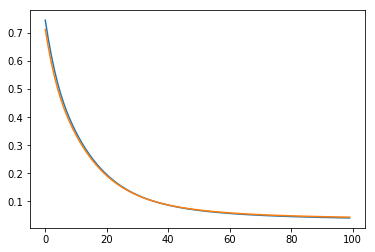

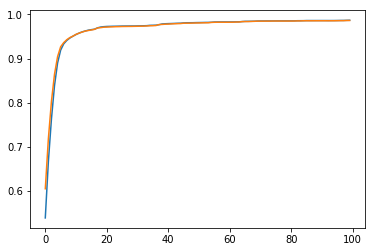

In [6]:
h = model.fit(x_train, y_train, epochs=100, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

#### With negatives

In [14]:
x_train_n, y_train_n = utils.create_dataset(f1.sentences_fr_train, f1, with_negatives=True)
x_train_n.shape, y_train_n.shape

((713276, 37), (713276, 39))

In [15]:
x_test_, y_test_ = utils.create_dataset(f1.sentences_fr_dev, f1, with_negatives=True)
x_test_.shape, y_test_.shape

((20040, 37), (20040, 39))

In [9]:
model_n = keras.models.Sequential()
model_n.add(keras.layers.Dense(39, activation='softplus', input_dim=37))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

model_n.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
model_n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 39)                1482      
Total params: 1,482
Trainable params: 1,482
Non-trainable params: 0
_________________________________________________________________


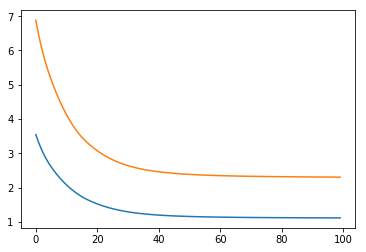

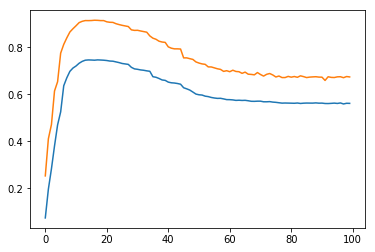

In [10]:
h = model_n.fit(x_train_n, y_train_n, epochs=100, batch_size=1024, validation_data=(x_test_n, y_test_n), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

### Some tests

In [26]:
for s in sentence:
    print(s)
    x, _ = f1.create_example(s, sentence[int(s[f1.governor_i])])
    prediction = model.predict(x.reshape(1, -1))[0]
    prediction_n = model_n.predict(x.reshape(1, -1))[0]
    
    i2 = np.argmax(prediction[2:])
    label2 = utils.onehot_2_label[i]
    print('Without negatives :', label2, prediction[i2+2], prediction[:2])

    i = np.argmax(prediction_n[2:])
    label = utils.onehot_2_label[i]
    print('With negatives :', label, prediction_n[i+2], prediction_n[:2], '\n')

['0' 'ROOT' '0' 'root']
Without negatives : punct 0.82372695 [0.04273215 0.9498972 ]
With negatives : root 3.730026 [1.5379279e-03 3.2963409e+00] 

['1' 'ADV' '5' 'advmod']
Without negatives : root 0.69907355 [0.9774086  0.02425681]
With negatives : advmod 1.4384844 [2.014942   0.03773335] 

['2' 'PUNCT' '5' 'punct']
Without negatives : advmod 0.8843441 [0.99406046 0.00942963]
With negatives : punct 3.264047 [2.9647250e+00 8.5019675e-04] 

['3' 'DET' '4' 'det']
Without negatives : punct 0.9315976 [0.9832971  0.01750697]
With negatives : det 2.3556888 [2.386002  0.0035459] 

['4' 'NOUN' '5' 'nsubj']
Without negatives : det 0.22905555 [0.5608604 0.4428298]
With negatives : nsubj 0.30456993 [0.720085  0.5040278] 

['5' 'VERB' '0' 'root']
Without negatives : nsubj 0.5633286 [0.1127452 0.8705779]
With negatives : obl 1.7901536 [0.45987493 3.1041706 ] 

['6' 'DET' '7' 'det']
Without negatives : obl 0.9315976 [0.9832971  0.01750697]
With negatives : det 2.3556888 [2.386002  0.0035459] 

['7' 

### Eisner's algorithm

Now we have our model, we can use it to create the dependency parsing itself with Eisner's algorithm. 

[Explanatory video](https://youtu.be/du9VQaFEyeA)

In [16]:
full_left, full_right, part, labels = utils.eisner(sentence, f1, model)
full_left_n, full_right_n, part_n, labels_n = utils.eisner(sentence, f1, model_n)
true_full_left, true_full_right, true_part, true_labels = utils.eisner(sentence, f1, perfect=True)

### Decomposition

In [29]:
sentence_predicted = utils.predict_sentence(sentence, f1, full_left, full_right, part, labels)
pd.DataFrame(sentence_predicted)

,0,1,2,3
0,0,ROOT,0,root
1,1,ADV,5,advmod
2,2,PUNCT,5,punct
3,3,DET,5,det
4,4,NOUN,5,nsubj
5,5,VERB,8,punct
6,6,DET,5,det
7,7,NOUN,5,obl
8,8,PUNCT,0,punct


In [32]:
utils.compare(pd.DataFrame(sentence_predicted)[[f1.governor_i, f1.label_i]], pd.DataFrame(sentence)[[f1.governor_i, f1.label_i]])

,2,3
0,True,True
1,True,True
2,True,True
3,False,True
4,True,True
5,False,False
6,False,True
7,True,False
8,False,True


In [34]:
sentence_predicted = utils.predict_sentence(sentence, f1, full_left_n, full_right_n, part_n, labels_n)
pd.DataFrame(sentence_predicted)

,0,1,2,3
0,0,ROOT,0,root
1,1,ADV,5,advmod
2,2,PUNCT,5,punct
3,3,DET,5,det
4,4,NOUN,5,nsubj
5,5,VERB,8,punct
6,6,DET,5,det
7,7,NOUN,5,obl
8,8,PUNCT,0,punct


In [36]:
utils.compare(pd.DataFrame(sentence_predicted)[[f1.governor_i, f1.label_i]], pd.DataFrame(sentence)[[f1.governor_i, f1.label_i]])

,2,3
0,True,True
1,True,True
2,True,True
3,False,True
4,True,True
5,False,False
6,False,True
7,True,False
8,False,True


### LAS scores

In [41]:
sentences_test = utils.predict_sentences('UD_French-GSD/fr_gsd-ud-test.conllu', f1, model=model)
utils.write_conllu(sentences_test, f1, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test.conll')
utils.score_las('fr_test.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

0.1091816367265469

In [45]:
sentences_test = utils.predict_sentences('UD_French-GSD/fr_gsd-ud-test.conllu', f1, model=model_n)
utils.write_conllu(sentences_test, f1, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test_n.conll')
utils.score_las('fr_test_n.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

0.24231536926147704

## F2 features

In [2]:
sentence = f2.sentences_fr_train[3]
pd.DataFrame(sentence)

,0,1,2,3,4,5
0,0,ROOT,ROOT,_,0,root
1,1,toutefois,ADV,_,5,advmod
2,2,",",PUNCT,_,5,punct
3,3,le,DET,Definite=Def|Gender=Fem|Number=Plur|PronType=Art,4,det
4,4,fille,NOUN,Gender=Fem|Number=Plur,5,nsubj
5,5,adorer,VERB,Mood=Ind|Number=Plur|Person=3|Tense=Pres|VerbF...,0,root
6,6,le,DET,Definite=Def|Gender=Masc|Number=Plur|PronType=Art,7,det
7,7,dessert,NOUN,Gender=Masc|Number=Plur,5,obj
8,8,.,PUNCT,_,5,punct


## Morphology Exploration

In [23]:
morphos, no_morpho_count, word_count = f2.count_morphos(f2.sentences_fr_train)
no_morpho_count, word_count, '%.2f %%' % (no_morpho_count / word_count * 100)

(172186, 371192, '46.39 %')

In [19]:
inputs_count = 0
for m in morphos:
    inputs_count += len(m)
inputs_count

86

In [27]:
morphos

{'Definite': Counter({'Def': 38331, 'Ind': 9023}),
 'Gender': Counter({'Fem': 66409, 'Masc': 89525, 'Neut': 2}),
 'Mood': Counter({'Cnd': 386, 'Imp': 109, 'Ind': 21317, 'Sub': 347}),
 'NumType': Counter({'Ord': 174}),
 'Number': Counter({'Plur': 43280, 'Sing': 140866}),
 'Person': Counter({'1': 1723, '2': 527, '3': 31007}),
 'Polarity': Counter({'Neg': 2550}),
 'Poss': Counter({'Yes': 3908}),
 'PronType': Counter({'Art': 47279,
          'Dem': 3380,
          'Ind': 3,
          'Int': 1,
          'Neg': 108,
          'Prs': 13104,
          'Rel': 3062}),
 'Reflex': Counter({'Yes': 95}),
 'Tense': Counter({'Fut': 740, 'Imp': 1812, 'Past': 12229, 'Pres': 19744}),
 'VerbForm': Counter({'Fin': 22159, 'Inf': 5511, 'Part': 12363})}

In [26]:
f2.remove_morpho(['Case', 'Degree'], f2.sentences_fr_train, morphos)

In [28]:
morphos_vec = f2.morpho_2_vec(morphos)

In [29]:
print(sentence[3][f2.morpho_i])
f2.convert_morpho(sentence[3], morphos_vec)

Definite=Def|Gender=Fem|Number=Plur|PronType=Art


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Embeddings

In [8]:
txts = []
for s in sentences:
    txts.append(list(s.T[lemma_i]))

In [9]:
word2vec = Word2Vec(txts, size=100, window=5, min_count=1, workers=20, iter=13)

In [11]:
word2vec.most_similar('homme')

[(':', 0.9999552965164185),
 ('avec', 0.9999533891677856),
 ('pour', 0.9999516010284424),
 ('contre', 0.9999505281448364),
 ('en', 0.9999502301216125),
 ('dont', 0.9999480247497559),
 ('nouveau', 0.9999476671218872),
 ('par', 0.9999459981918335),
 ('tout', 0.9999454617500305),
 ('année', 0.9999446868896484)]

In [7]:
embeddings = f2.load_embedding_tsv('embeddings/fr.tsv')

In [25]:
for w, d in f2.most_similar('homme', embeddings):
    print(w, d)

aventurier 0.3812869298843866
aristocrate 0.41586075197264827
garçon 0.42669343291005124
vieillard 0.42848045450211325
délinquant 0.4517847652614828
écrivain 0.462098919208601
politicien 0.4643771199670472
escroc 0.46441918350310585
orateur 0.47624799682468577
érudit 0.4801901703996774


In [26]:
for w, d in f2.most_similar('femme', embeddings):
    print(w, d)

servante 0.27001328890807663
mère 0.27587044941978245
fille 0.28304991668249113
belle-mère 0.3160642425882113
fiancée 0.32169272506347235
compagne 0.3242348885116416
sœur 0.3276623007064734
prostituée 0.3331958262205478
nourrice 0.334836847918482
demi-sœur 0.3499454120589943


In [8]:
mean_embedding = f2.default_embedding(embeddings, len(embeddings['homme']))

## Data

In [31]:
x_train, y_train = utils.create_dataset(f2.sentences_fr_train, f2, morphos_vec, embeddings, mean_embedding, with_negatives=False)
x_train.shape, y_train.shape

((356638, 793), (356638, 39))

In [32]:
x_test, y_test = utils.create_dataset(f2.sentences_fr_dev, f2, morphos_vec, embeddings, mean_embedding, with_negatives=False)
x_test.shape, y_test.shape

((35768, 793), (35768, 39))

## Model

In [33]:
modelf2 = keras.models.Sequential()
modelf2.add(keras.layers.Dense(393, activation='sigmoid', input_dim=793))
modelf2.add(keras.layers.Dense(150, activation='sigmoid'))
modelf2.add(keras.layers.Dense(39, activation='softplus'))

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/{}".format(time.time()))
opt = keras.optimizers.Adam(lr=0.0001)

modelf2.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
modelf2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 393)               312042    
_________________________________________________________________
dense_8 (Dense)              (None, 150)               59100     
_________________________________________________________________
dense_9 (Dense)              (None, 39)                5889      
Total params: 377,031
Trainable params: 377,031
Non-trainable params: 0
_________________________________________________________________


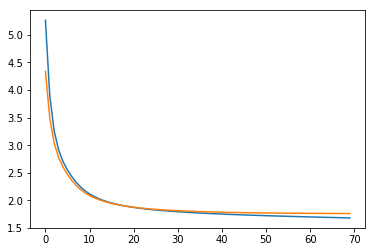

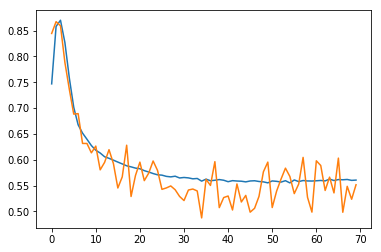

In [34]:
h = modelf2.fit(x_train, y_train, epochs=70, batch_size=1024, validation_data=(x_test, y_test), verbose=0, callbacks=[tensorboard])

x_plt = np.arange(len(h.history['loss']))
plt.plot(x_plt, h.history['loss'], label='train')
plt.plot(x_plt, h.history['val_loss'], label='test')
plt.show()

plt.plot(x_plt, h.history['acc'], label='train')
plt.plot(x_plt, h.history['val_acc'], label='test')
plt.show()

## Eisner

In [35]:
sentences_test = utils.predict_sentences(
    'UD_French-GSD/fr_gsd-ud-test.conllu', 
     f2, 
     morphos_vec, 
     embeddings,
     mean_embedding, 
     model=modelf2, 
     features_enabled=[0, 2, 3, 5, 6, 7], 
     root=[0, 'ROOT', 'ROOT', '_', 0, 'root']
)
utils.write_conllu(sentences_test, f2, 'UD_French-GSD/fr_gsd-ud-test.conllu', 'fr_test_f2_n.conll')
utils.score_las('fr_test_f2_n.conll', 'UD_French-GSD/fr_gsd-ud-test.conllu')

0.5947105788423154